In [6]:
"""
CS 677 Data Science with Python
#########################################
Module          - HW 4
Creation Date   - 23/02/2019
Student Name    - Gautam Gowrishankar
"""
import os
import pandas as pd
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from statistics import median,mean

#input file 
input_dir = r'/Users/arun/Downloads/CS677 - PY/'
input_file  = os.path.join(input_dir, 'GPS_MOD.csv')


df = pd.read_csv(input_file)
df.head(5)

,Date,Year,Month,Day,Weekday,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2014-01-02,2014,1,2,Thursday,39.630001,38.660000,38.720001,4785200.0,32.561630,0.000000,32.561630,32.561630
1,2014-01-03,2014,1,3,Friday,39.750000,38.730000,39.520000,4437000.0,33.234386,0.020661,32.898008,32.898008
2,2014-01-06,2014,1,6,Monday,39.630001,38.799999,39.049999,4514200.0,33.006180,-0.006867,32.934066,32.934066
3,2014-01-07,2014,1,7,Tuesday,39.990002,39.090000,39.340000,6683300.0,33.251289,0.007426,33.013371,33.013371
4,2014-01-08,2014,1,8,Wednesday,39.330002,38.619999,39.200001,6951600.0,33.132961,-0.003559,33.037289,33.037289


In [8]:
""""
#Task 1: Add naïve strategy 
"""
df1 = df[["Adj Close","Return"]].copy() #create a subset, deal with that going forward
df1["Buy/Sell"] = df1["Return"].apply(lambda x: "Buy" if x < 0 else "Sell") #to make life easier
df1["Buy/Sell"] = df1["Buy/Sell"].shift(1) #as current day's action is to be carried out the next day
ownStock = False
win,loss = [],[]
x,revenue = 0,0
for index, row in df1.iterrows():
    if row["Buy/Sell"] == "Sell":
        if ownStock:
            revenue = (row["Adj Close"] * numberOfShares) - (stockCost * numberOfShares) 
            win.append(round(revenue,3)) if revenue > 0 else loss.append(round(revenue,3))
            ownStock = False
    else:
        if ownStock:
            #do nothing
            x+=1
        else:
            #buy
            numberOfShares = 100 // row["Adj Close"] #$100 as the investment
            stockCost = row["Adj Close"]
            ownStock = True
print("Using Naive Strategy:\nMean stock gain is:",round(mean(win),3),"\nMean stock loss is:",round(mean(loss),3))


Using Naive Strategy:
Mean stock gain is: 1.501 
Mean stock loss is: -1.726


In [13]:
""""
#Task 2: Labeling Data
"""
#Note: Considering the whole dataset for processing for achieving better classification 
#i.e. all of the four years and not restricting to any particular year
df2 = df[df["Weekday"]=="Thursday"].copy() #Since my input starts on a thursday, consider it as 1st day of week 
df2['idx'] = df2.index - 1
df2['idx'] = df2["idx"].shift(-1) #index of week's ending day
df2["idx"].fillna((len(df)-1),inplace=True) #fix the last value, since we are shifting up
df2.drop(df2.columns.difference(['Adj Close','Return','idx']),1,inplace=True)

#Calulate the weekly returns
#Idx column in df2 is nothing but the index of a particular week's last day
#Actual index 'i' and 'idx' from df2 together form the boundaries of a week
weeklyReturns = []
indices = []
for i,r in df2.iterrows():
    returns = 100*((df["Adj Close"].loc[r["idx"]] - df["Adj Close"].loc[i])/df["Adj Close"].loc[i])
    weeklyReturns.append(round(returns,3))
    indices.append((i,r["idx"]))

#Calculating the weekly mean, standard deviation and creating a df from that info
week = 0
dicts = {}
for x,y in indices:
    week +=1
    dicts[week] = (df["Return"][x:int(y)].mean(),df["Return"][x:int(y)].std())

#Labeling Rationale: 
#If the mean returns for a particular week is positive, 
#label it as a favourable one i.e. Green else Red
dfResult = pd.DataFrame.from_dict(dicts, orient='index').reset_index()
dfResult.columns = ['Week','Mean','S.Dev']
dfResult['Label'] = dfResult['Mean'].apply(lambda x: 'Red' if x < 0 else 'Green') #labeling
dfResult.head(5)

,Week,Mean,S.Dev,Label
0,1,0.005305,0.011784,Green
1,2,-0.009702,0.023031,Red
2,3,0.006638,0.017941,Green
3,4,-0.011815,0.008984,Red
4,5,0.007268,0.023595,Green


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


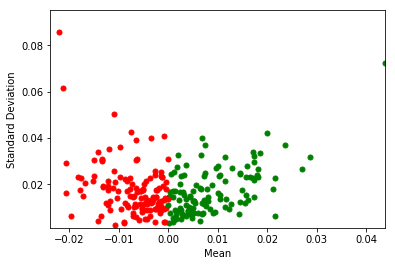

In [15]:
#set up the axes
X = np.array(dfResult['Mean'])
Y = np.array(dfResult['S.Dev'])
fig = plt.figure()
ax = plt.gca()
#set up X,Y scale
ax.set_xlim(0.5*min(X), max(X))
ax.set_ylim(0.5*min(Y), max(Y))
ax.set_xlabel('Mean')
ax.set_ylabel('Standard Deviation')
text_font = {'fontname':'Arial', 'size':'12', 
             'color':'black', 'weight':'normal',
              'verticalalignment':'top'} 
#Plot
for i in range(len(X)):
    color = 'green'
    if X[i] < 0:     
        color = 'red'
    ax.scatter(X[i], Y[i], color=color, s = 25)
fig.show()
#Green spots indicating a favourable week